In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *
from matplotlib import cm
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.models as models

In [2]:
writer = SummaryWriter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
from google.colab import drive
drive.mount('/content/gdrive/');

# Load the dataset and apply data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=224),
    # transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cuda
Mounted at /content/gdrive/


In [3]:
def load_Data():
  train_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/train"
  test_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/test"
  val_dir = "/content/gdrive/MyDrive/Final_Dataset/dataset2/val"
  # train_dir = "/content/gdrive/MyDrive/test/dataset1/train"
  # test_dir = "/content/gdrive/MyDrive/test/dataset1/test"
  # val_dir = "/content/gdrive/MyDrive/test/dataset1/val"
  trainset = datasets.ImageFolder(train_dir, train_transform)
  testset = datasets.ImageFolder(test_dir, val_transform)
  valset = datasets.ImageFolder(val_dir, val_transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
  valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=8)
  return trainloader,testloader,valloader
load_Data()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7f488a77eeb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f488a77e6d0>)

In [4]:
class ShuffleNetV2(nn.Module):
      def __init__(self, num_classes):
          super(ShuffleNetV2, self).__init__()
          self.num_classes = num_classes
          # self.model = torch.hub.load('pytorch/vision', 'shufflenet_v2_x1_0', pretrained=True)
          self.model = models.shufflenet_v2_x1_0(pretrained=False)
          self.model.fc = nn.Linear(in_features=1024, out_features=num_classes)
          # print(self.model.fc)
          self.model.classifier = self.model.fc

          self.features = {}
          self.model.classifier.register_forward_pre_hook(self.get_features("embeddings"))
      
      # def get_features(self,name):
      #   def hook(model):
      #     self.features[name] = input[0].detach().cpu().numpy()
      #     return hook
      def get_features(self,name):
        def hook(model, input):
          self.features[name] = input[0].detach().cpu().numpy()
        return hook
      def forward(self,x):
          x = self.model(x)
          return x
model = ShuffleNetV2(5)
print(model)

ShuffleNetV2(
  (model): ShuffleNetV2(
    (conv1): Sequential(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage2): Sequential(
      (0): InvertedResidual(
        (branch1): Sequential(
          (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
          (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): ReLU(inplace=True)
        )
        (branch2): Sequential(
          (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNo

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
def save_checkpoint(state, filename):
  torch.save(state, filename)

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
# datastructure to store all the training testing and validation results.
y_train = []
y_expected_train = []
y_val = []
y_expected_val = []
y_test = []
y_expected_test = []
trainloss = []
valloss =[]
epochnum = []  

In [8]:
print(torch.cuda.is_available())
def train(model, train_loader, criterion, optimizer, epoch, step=5):
    
    model.train()
    loss_list = AverageMeter()
    for i, (images, labels) in enumerate(train_loader):
        #print(torch.cuda.is_available())
        total =0
        correct = 0
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        #print(predicted,type(predicted))
        #print(labels,type(labels))
        output = model(images)
        loss = criterion(output,labels)
        loss_list.update(loss.data, images.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(output.data, 1)
        y_train.extend(predicted.to(torch.device('cpu')))
        y_expected_train.extend(labels.to(torch.device('cpu')))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        #print( f'Training Accuracy: {accuracy:.2f}%')
            
        if i%step==0:
            print('EPOCH {} | ITER {} | AVG_LOSS {} | Train_ACC {}'.format(epoch, i, loss_list.avg,accuracy))
        writer.add_scalar('TRAIN_LOSS', loss, epoch)
        writer.add_scalar('TRAIN_ACC', accuracy, epoch)
        
    return loss ,accuracy

True


In [9]:
def val(model, val_loader, criterion, optimizer, epoch, step=5):
    model.eval()
    loss_list = AverageMeter()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            #print("Inside validation");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            loss = criterion(outputs,labels)
            loss_list.update(loss.data, inputs.size(0))
            y_val.extend(predicted.to(torch.device('cpu')))
            y_expected_val.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #print("CORRECT",correct)
            #print("Total",total)
        accuracy = 100 * correct / total
        print(f'Val Accuracy: {accuracy:.2f}%')
        # writer.add_scalar('Validation_LOSS', loss, epoch)
        writer.add_scalar('Validation_ACCURACY', accuracy, epoch)
        return loss,accuracy
    

In [10]:
def test(model, test_loader, criterion, optimizer, epoch, step=5):
    print("Best Model: ",epoch)
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        print("*"*40)
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            #print("Inside test");
            #print(inputs.shape)
            #print(labels.shape)
            labels = labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,type(predicted))
            #print(labels,type(labels))
            y_test.extend(predicted.to(torch.device('cpu')))
            y_expected_test.extend(labels.to(torch.device('cpu')))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'test Accuracy: {accuracy:.2f}%')
        # writer.add_scalar('_LOSS', loss, epoch)
        # writer.add_scalar('TEST_ACC', accuracy, epoch)
        return accuracy
    

In [11]:
def visualize(model , data_loader):
    class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}
    idx2class = { value : key for key,value in  class2idx.items() }
    embeddings = np.array([])
    labels = np.array([])
    model.eval()
    out_features = 1024
    num_categories = 5
    with torch.no_grad(): 
        for i,data in enumerate(data_loader):
            images, labs = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            embeds = model.features["embeddings"].reshape(-1, 1024)
            embeddings = np.append(embeddings , embeds)
            labels = np.append(labels,labs.cpu())
  
    embeddings = embeddings.reshape(-1, 1024)
    
    c_labels = labels.reshape(-1 , 1).ravel()
    tsne = TSNE(n_components=2,perplexity=2).fit_transform(embeddings)
    labels = np.array([ idx2class[ele] for ele in c_labels])
    
    cmap = cm.get_cmap('tab20')
    
    for lab in range(num_categories):
        indices = (c_labels == lab)
        plt.scatter(tsne[indices, 0],tsne[indices, 1],c=np.array(cmap(lab)).reshape(1, 4),label=lab,alpha=1)
        plt.legend(fontsize='large', markerscale=2)
    plt.show()
  
# model = Model((224,224))
# train_loader, val_loader ,test_loader = load_Data()
# visualize(model,test_loader)


In [12]:
def plotloss():
  plt.figure(figsize=(20,10))
  plt.plot(epochnum, trainloss)
  plt.plot(epochnum, valloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.show()


In [13]:
class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}
idx2class = { value : key  for key , value in class2idx.items() }

def plot_confusion_matrix(data, labels, metrics ,output_filename=None):

    [macro_precision , micro_precision , macro_recall , micro_recall] = metrics

    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(10,10))
 
    plt.suptitle("Confusion Matrix")
    plt.title(f"(Macro/Micro) Precision : {round(macro_precision,2)}/{round(micro_precision,2)}   :::::   (Macro/Micro) Recall : {round(macro_recall,2)}/{round(micro_recall,2)}")
 
    seaborn.set(font_scale=1)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu",linewidths=2 , fmt='d' ,cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()



True
using gpu
EPOCH 0 | ITER 0 | AVG_LOSS 1.6823952198028564 | Train_ACC 12.5
EPOCH 0 | ITER 5 | AVG_LOSS 1.6395810842514038 | Train_ACC 25.0
EPOCH 0 | ITER 10 | AVG_LOSS 1.6118686199188232 | Train_ACC 25.0
EPOCH 0 | ITER 15 | AVG_LOSS 1.5784355401992798 | Train_ACC 40.625
EPOCH 0 | ITER 20 | AVG_LOSS 1.5611252784729004 | Train_ACC 46.875
EPOCH 0 | ITER 25 | AVG_LOSS 1.5470167398452759 | Train_ACC 46.875
EPOCH 0 | ITER 30 | AVG_LOSS 1.5273319482803345 | Train_ACC 25.0
EPOCH 0 | ITER 35 | AVG_LOSS 1.5208936929702759 | Train_ACC 37.5
EPOCH 0 | ITER 40 | AVG_LOSS 1.5175564289093018 | Train_ACC 37.5
EPOCH 0 | ITER 45 | AVG_LOSS 1.511070728302002 | Train_ACC 40.625
EPOCH 0 | ITER 50 | AVG_LOSS 1.5038882493972778 | Train_ACC 37.5
EPOCH 0 | ITER 55 | AVG_LOSS 1.5033000707626343 | Train_ACC 31.25
EPOCH 0 | ITER 60 | AVG_LOSS 1.4992519617080688 | Train_ACC 46.875
EPOCH 0 | ITER 65 | AVG_LOSS 1.497760534286499 | Train_ACC 37.5
EPOCH 0 | ITER 70 | AVG_LOSS 1.4976290464401245 | Train_ACC 43.75
EP

<ipython-input-11-7e0b9f71cfa1>:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')


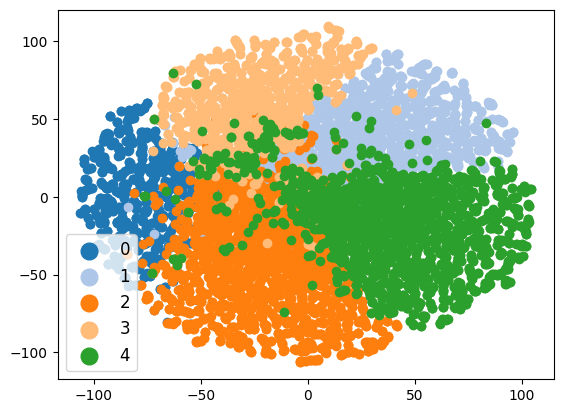

In [14]:
def main():
    model = ShuffleNetV2(5);
    print(torch.cuda.is_available())
    if torch.cuda.is_available():
        model = model.cuda()
        print("using gpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epochs = 30
    train_loader, val_loader ,test_loader = load_Data()
 
    history = open("/content/gdrive/MyDrive/Results/dataset2_Shufflenetv2_history.csv",'w')
    history.write('epochs , trainloss , Train-acc,val_acc , test_acc \n')
    max_accuracy = 0 
    finalepoch  = 0 
    for epoch in range(0,epochs):
        start = time.time()
        train_loss,accuracy = train(model, train_loader, criterion, optimizer, epoch)
        vallosss,val_loss = val(model, val_loader, criterion, optimizer, epoch)
        
        trainloss.append(train_loss.cpu().detach().numpy())
        valloss.append(vallosss.cpu().detach().numpy())
        epochnum.append(epoch)
        print()
        print('-' * 50)
        print('EPOCH {} | LOSS {} | TIME {}'.format(epoch, train_loss, time.time() - start))
        print('-' * 50)
        print()

        if(val_loss > max_accuracy):
          max_accuracy = val_loss
          finalepoch  = epoch
          save_checkpoint({'epoch': epoch,'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),'loss' : train_loss}, "/content/gdrive/MyDrive/Checkpoints/dataset2_Shufflenetv2.ckpt")

        history.write('{},{},{},{}\n'.format(epoch, train_loss,accuracy, val_loss ))
    test_loss = test(model, test_loader, criterion, optimizer, epoch)    
    history.close()
    visualize(model,train_loader)
# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()

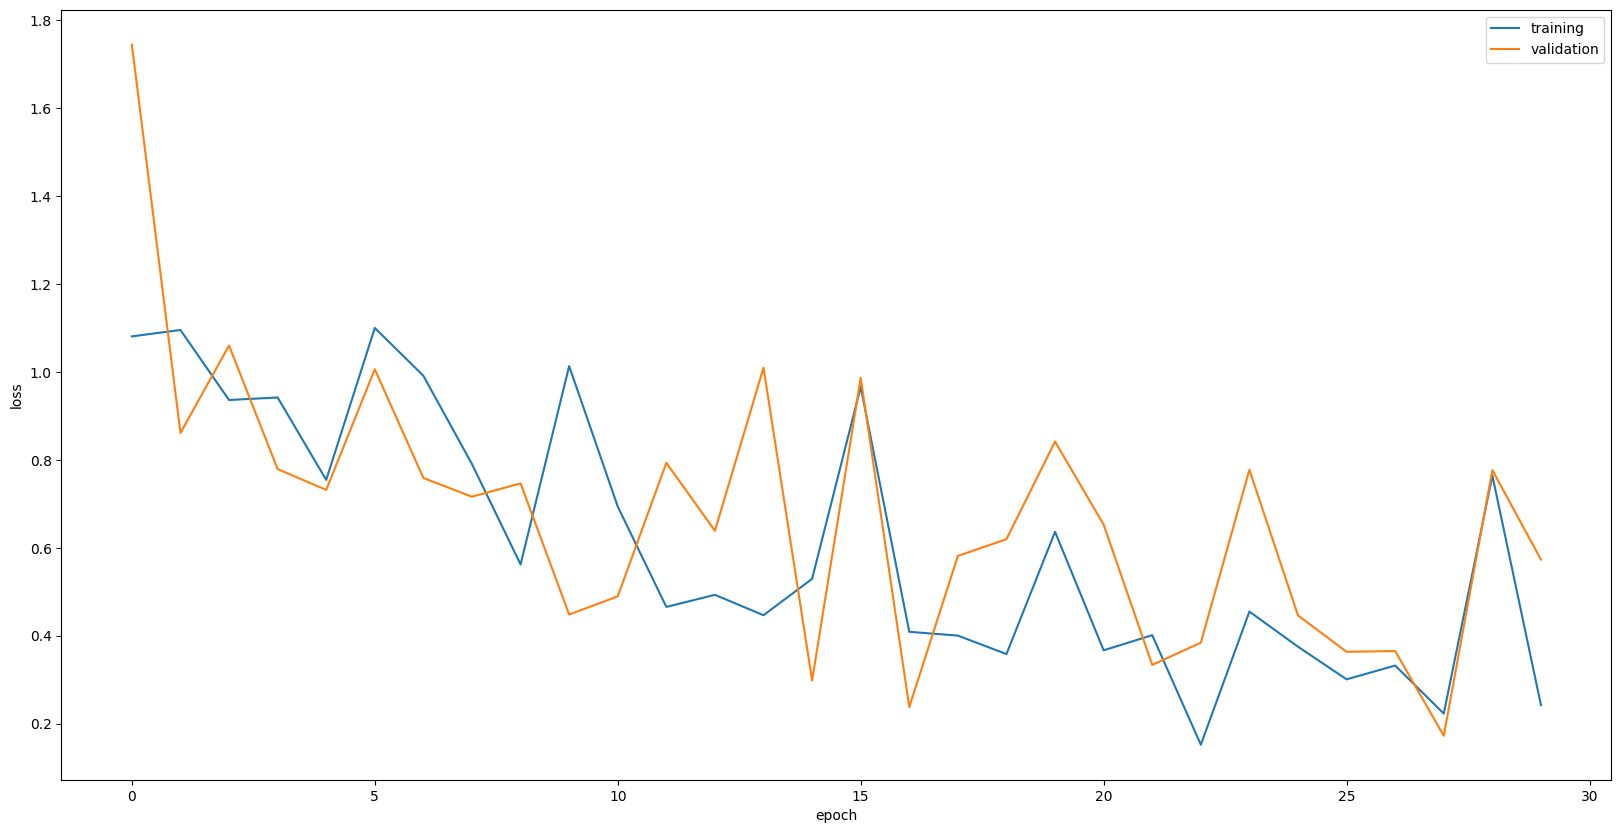

In [15]:
plotloss()

f1 - Score is :---  0.7982017982017982


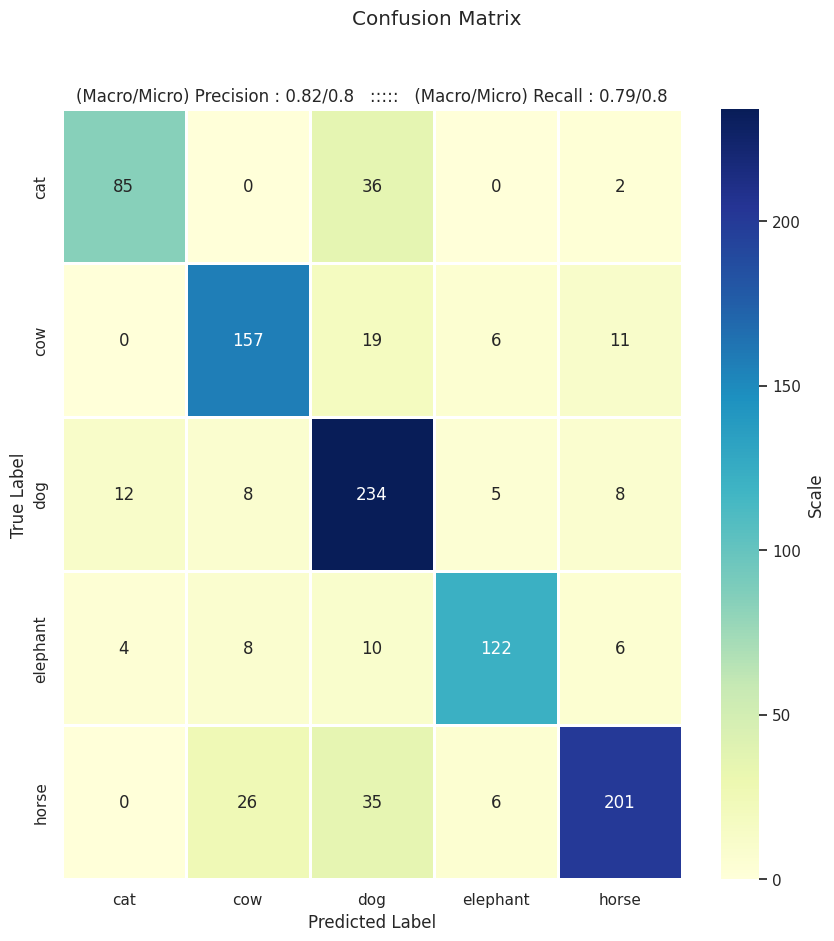

In [16]:
class2idx = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'horse': 4}

idx2class = { value : key  for key , value in class2idx.items() }
y_true = [idx2class[val.item()] for val in y_expected_test ]
y_pred = [idx2class[val.item()] for val in y_test ]

macro_precision = precision_score(y_true, y_pred, average="macro")
macro_recall = recall_score(y_true, y_pred, average="macro")
micro_precision = precision_score(y_true, y_pred, average="micro")
micro_recall = recall_score(y_true, y_pred, average="micro")
f1_score = (2*micro_precision*micro_recall)/(micro_recall + micro_precision)

print("f1 - Score is :--- " ,f1_score)
cnf_matrix = confusion_matrix(y_true , y_pred , labels=['cat','cow','dog','elephant','horse'])
plot_confusion_matrix(cnf_matrix , class2idx.keys() , [macro_precision , micro_precision , macro_recall , micro_recall], output_filename = "cnf_mobilenet_Data1.png")